# Stress Analysis in Social Media

Leverage the newly published and labelled reddit dataset for stress analysis to develop and improve supervised learning methods for identifying stress, both neural and traditional, and analyze the complexity and diversity of the data and characteristics of each category.

Reference: https://towardsdatascience.com/nlp-performance-of-different-word-embeddings-on-text-classification-de648c6262b


In [1]:
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import re
import string
from collections import defaultdict

import nltk
from nltk.corpus import stopwords
from nltk.corpus import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
# from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

# from wordcloud import WordCloud

from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

ModuleNotFoundError: No module named 'xgboost'

In [2]:
# Mount gdrive
from google.colab import drive
drive.mount('gdrive')
%cd gdrive/My Drive/Insights

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at gdrive
/content/gdrive/My Drive/Insights


In [2]:
import warnings
warnings.filterwarnings("ignore")

## Data Preprocessing
Possible approach of data preprocessing and feature engineeing 
- Tokenization, Removal of punctuations.
- Removal of commonly used words (stopwords).
- Lemmatization or Stemming (Normalization)

In [0]:
nltk.download('stopwords')
nltk.download('wordnet')

path = './data/'
train = pd.read_csv(path + 'dreaddit-train.csv', encoding = "ISO-8859-1")
test = pd.read_csv(path + 'dreaddit-test.csv', encoding = "ISO-8859-1")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Tokenization & Remove punctuations

In [0]:
# tokenization: breaks the string into list of words
# tokenizer = RegexpTokenizer(r'\w+')
tokenizer = RegexpTokenizer(r'[a-zA-Z]{2,}') # remove number and words that length = 1
train['processed_text'] = train['text'].apply(lambda x: tokenizer.tokenize(x.lower()))
test['processed_text'] = test['text'].apply(lambda x: tokenizer.tokenize(x.lower()))

### Remove Stopwords

In [0]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

In [0]:
train['processed_text'] = train['processed_text'].apply(lambda x: remove_stopwords(x))
test['processed_text'] = test['processed_text'].apply(lambda x: remove_stopwords(x))

### Stemming & Lemmatization
Text normalization

In [0]:
# stemming
stemmer = PorterStemmer()

def word_stemmer(text):
    stem_text = [stemmer.stem(i) for i in text]
    return stem_text

train['processed_text'] = train['processed_text'].apply(lambda x: word_stemmer(x))
test['processed_text'] = test['processed_text'].apply(lambda x: word_stemmer(x))

In [0]:
# lemmatization
lemmatizer = WordNetLemmatizer()

def word_lemmatizer(text):
    lem_text = [lemmatizer.lemmatize(i) for i in text]
    return lem_text

train['processed_text'] = train['processed_text'].apply(lambda x: word_lemmatizer(x))
test['processed_text'] = test['processed_text'].apply(lambda x: word_lemmatizer(x))

In [0]:
train.to_pickle("./data/train.pkl")
test.to_pickle("./data/test.pkl")

## Feature Extraction

### Word2Vec + TD-IDF
TF-IDF Weighted Averaging on Word Embedding

reference: https://gist.github.com/TomLin/30244bcccb7e4f94d191a878a697f698

In [8]:
path = '../../data/preprocessed/'
train = pd.read_pickle(path + "train.pkl")
test = pd.read_pickle(path + "test.pkl")

In [13]:
train.subreddit.unique()

array(['ptsd', 'assistance', 'relationships', 'survivorsofabuse',
       'domesticviolence', 'anxiety', 'homeless', 'stress',
       'almosthomeless', 'food_pantry'], dtype=object)

In [0]:
word2vec = Word2Vec(train['processed_text'],
                size=300,
                window=10,
                min_count=2,
                workers=10,
                iter=100)

### Word2Vec

### plot samples

In [0]:
# find the similar words
semantically_similar_words = {words: [item[0] for item in word2vec.wv.most_similar([words], topn=5)]
                  # for words in ['abuse', 'anxiety', 'financial', 'ptsd', 'social', 'stress', 'love', 'friendship']}
                  for words in ['ptsd', 'social', 'stress', 'love', 'friendship']}

for k,v in semantically_similar_words.items():
    print(k+":"+str(v))

ptsd:['disord', 'kavanaugh', 'diagnos', 'miseri', 'em']
social:['interact', 'shi', 'medium', 'discord', 'volunt']
stress:['everyday', 'throw', 'knot', 'surround', 'slew']
love:['passion', 'happi', 'sweet', 'fun', 'dreamt']
friendship:['jessi', 'beyond', 'woman', 'humor', 'avenu']


In [0]:
# find the similarity of two words
print(word2vec.wv.similarity(w1='love', w2='stress'))

0.15093286


In [0]:
keys = ['ptsd', 'social', 'stress', 'love', 'friendship']
embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in word2vec.wv.most_similar(word, topn=20):
        words.append(similar_word)
        embeddings.append(word2vec[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [0]:
from sklearn.manifold import TSNE
import numpy as np

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

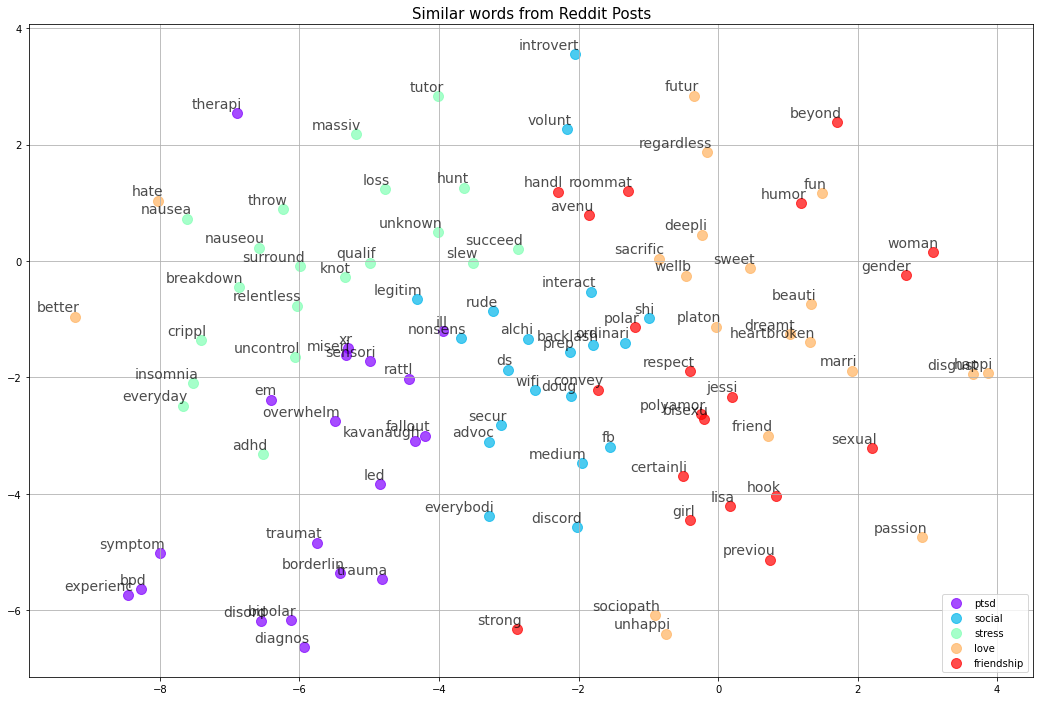

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline


def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(18, 12))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, s=100, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.7, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=14)
    plt.legend(loc=4) # , prop={'size': 20}
    plt.title(title, size=15)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()
    plt.savefig('./figs/similar_words.png')


tsne_plot_similar_words('Similar words from Reddit Posts', keys, embeddings_en_2d, word_clusters, 0.7)

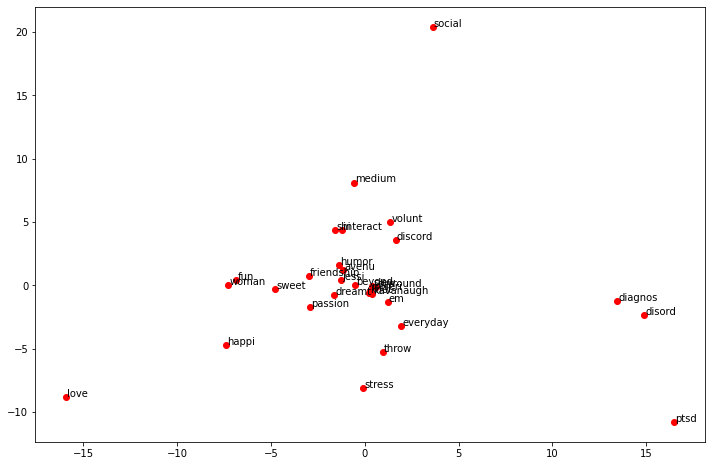

In [0]:
all_similar_words = sum([[k] + v for k, v in semantically_similar_words.items()], [])

word_vectors = word2vec.wv[all_similar_words]

pca = PCA(n_components=2)

p_comps = pca.fit_transform(word_vectors)
word_names = all_similar_words

plt.figure(figsize=(12, 8))
# name = ['abuse', 'anxiety', 'financial', 'ptsd', 'social', 'stress', 'love']
plt.scatter(p_comps[:, 0], p_comps[:, 1], c='red')

for word_names, x, y in zip(word_names, p_comps[:, 0], p_comps[:, 1]):
    plt.annotate(word_names, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')

### generate embeddings

In [0]:
class TfidfEmbeddingVectorizer(object):

    def __init__(self, word_model):

        self.word_model = word_model
        self.word_idf_weight = None
        self.vector_size = word_model.wv.vector_size

    def fit(self, docs):  # comply with scikit-learn transformer requirement
        """
        Fit in a list of docs, which had been preprocessed and tokenized,
        such as word bi-grammed, stop-words removed, lemmatized, part of speech filtered.
        Then build up a tfidf model to compute each word's idf as its weight.
        Noted that tf weight is already involved when constructing average word vectors, and thus omitted.
        :param: pre_processed_docs: list of docs, which are tokenized
        :return: self
        """

        text_docs = []
        for doc in docs:
            text_docs.append(" ".join(doc))

        tfidf = TfidfVectorizer() # default 1-gram 
        tfidf.fit(text_docs)  # must be list of text string

        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of
        # known idf's
        max_idf = max(tfidf.idf_)  # used as default value for defaultdict
        self.word_idf_weight = defaultdict(lambda: max_idf,
                                           [(word, tfidf.idf_[i]) for word, i in tfidf.vocabulary_.items()])
        return self


    def transform(self, docs):  # comply with scikit-learn transformer requirement
        doc_word_vector = self.word_average_list(docs)
        return doc_word_vector


    def word_average(self, sent):
        """
        Compute average word vector for a single doc/sentence.
        :param sent: list of sentence tokens
        :return:
            mean: float of averaging word vectors
        """

        mean = []
        for word in sent:
            if word in self.word_model.wv.vocab:
                mean.append(self.word_model.wv.get_vector(word) * self.word_idf_weight[word])  # idf weighted

        if not mean:  # empty words
            # If a text is empty, return a vector of zeros.
            logging.warning("cannot compute average owing to no vector for {}".format(sent))
            return np.zeros(self.vector_size)
        else:
            mean = np.array(mean).mean(axis=0)
            return mean


    def word_average_list(self, docs):
        """
        Compute average word vector for multiple docs, where docs had been tokenized.
        :param docs: list of sentence in list of separated tokens
        :return:
            array of average word vector in shape (len(docs),)
        """
        return np.vstack([self.word_average(sent) for sent in docs])

In [0]:
train_token = train['processed_text']
test_token = test['processed_text']

X = train_token.append(test_token)
X = X.reset_index(drop=True)

In [0]:
tfidf_vec_tr = TfidfEmbeddingVectorizer(word2vec)

tfidf_vec_tr.fit(X)  # fit tfidf model first
tfidf_doc_vec = tfidf_vec_tr.transform(X)

### Doc2Vec

In [9]:
doc_words = train['processed_text'].append(test['processed_text'])
doc_words = doc_words.reset_index(drop = True)

doc_ids = doc_words.index
tagdocs = [TaggedDocument(words=words, tags=[tag]) for words, tag in zip(doc_words, doc_ids)]

NameError: name 'TaggedDocument' is not defined

In [0]:
class DocModel(object):

	def __init__(self, docs, **kwargs):
		"""
		:param docs: list of TaggedDocument
		:param kwargs: dictionary of (key,value) for Doc2Vec arguments
		"""
		self.model = Doc2Vec(**kwargs)
		self.docs = docs
		self.model.build_vocab([x for x in self.docs])

	def custom_train(self, fixed_lr=False, fixed_lr_epochs=None):
		"""
		Train Doc2Vec with two options, without fixed learning rate(recommended) or with fixed learning rate.
		Fixed learning rate also includes implementation of shuffling training dataset.
		:param fixed_lr: boolean
		:param fixed_lr_epochs: num of epochs for fixed lr training
		"""
		if not fixed_lr:
			self.model.train([x for x in self.docs],
					 total_examples=len(self.docs),
					 epochs=self.model.epochs)
		else: # change the learning rate during the training
			for _ in range(fixed_lr_epochs):
				self.model.train(utils.shuffle([x for x in self.docs]),
						 total_examples=len(self.docs),
						 epochs=1)
				self.model.alpha -= 0.002
				self.model.min_alpha = self.model.alpha  # fixed learning rate


	def test_orig_doc_infer(self):
		"""
		Use the original doc as input for model's vector inference,
		and then compare using most_similar()
		to see if model finds the original doc id be the most similar doc to the input.
		"""
		idx = np.random.randint(len(self.docs))
		print('idx: ' + str(idx))
		doc = [doc for doc in self.docs if doc.tags[0] == idx]
		inferred_vec = self.model.infer_vector(doc[0].words)
		print(self.model.docvecs.most_similar([inferred_vec]))  # wrap vec in a list

In [0]:
# Configure keyed arguments for Doc2Vec model.
dm_args = {
    'dm': 1,
    'dm_mean': 1,
    'vector_size': 300,
    'window': 5,
    'negative': 5,
    'hs': 0,
    'min_count': 2,
    'sample': 0,
    # 'workers': workers,
    'alpha': 0.025,
    'min_alpha': 0.025,
    'epochs': 100,
    'comment': 'alpha=0.025'
}
# Instantiate a pv-dm model.
dm = DocModel(docs=tagdocs, **dm_args)
dm.custom_train()

In [0]:
dm_doc_vec_ls = []
for i in range(len(dm.model.docvecs)):
    dm_doc_vec_ls.append(dm.model.docvecs[i])

dm_doc_vec = pd.DataFrame(dm_doc_vec_ls)
dm_doc_vec.shape

# print('Save dm doc2vec as csv file...')
# dir_path = os.getcwd()
# dm_doc_vec.to_csv(os.path.join(dir_path, 'dm_doc_vec.csv'), index=False, header=False)

(3553, 300)

## Classification

### Word Embedding + TF-IDF

In [0]:
scaler = StandardScaler()
tfidf_doc_vec_scaled = scaler.fit_transform(tfidf_doc_vec)

In [0]:
X_train = tfidf_doc_vec[:len(train)]
y_train = train['label']

X_test = tfidf_doc_vec[len(train):]
y_test = test['label']

D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

In [0]:
clf_dict = {'log reg': LogisticRegression(random_state=42), 
            'naive bayes': GaussianNB(), 
            'linear svc': LinearSVC(random_state=42),
            'sgd classifier': SGDClassifier(random_state=42),
            'ada boost': AdaBoostClassifier(n_estimators=100, random_state=42),
            'gradient boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
            'CART': DecisionTreeClassifier(random_state=42),
            'random forest': RandomForestClassifier(n_estimators=100, random_state=42)}

In [0]:
for name, clf in clf_dict.items():
    model = clf.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Accuracy of {}:'.format(name), accuracy_score(y_pred, y_test))


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy of log reg: 0.7188811188811188
Accuracy of naive bayes: 0.6559440559440559


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy of linear svc: 0.6881118881118881
Accuracy of sgd classifier: 0.6489510489510489
Accuracy of ada boost: 0.6979020979020979


KeyboardInterrupt: ignored

#### XGBoost

In [0]:
# on CPU:
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)
params = {"objective":'multi:softprob','colsample_bytree': 0.3, 'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10 , 'num_class': 2, 'random_state': 42}
steps = 20  # The number of training iterations
model = xgb.train(params, D_train, steps)
preds = model.predict(D_test)
y_pred = np.asarray([np.argmax(line) for line in preds])

# on GPU:
# params = {"objective":'multi:softprob','learning_rate': 0.1, 'alpha': 10 , 'num_class': 2, 
#           'random_state': 42, tree_method='gpu_hist', gpu_id=0}

# clf = xgb.XGBClassifier(params)
# parameters = {
#      "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
#      "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
#      "min_child_weight" : [ 1, 3, 5, 7 ],
#      "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
#      "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
#      }
# grid = GridSearchCV(clf,
#                     parameters, n_jobs=4,
#                     scoring="neg_log_loss",
#                     cv=3)

# grid.fit(X_train,y_train)
# grid.best_estimator_
# y_preds = grid.predict(X_test)
# y_pred = np.asarray([np.argmax(line) for line in y_preds])

In [0]:
name = 'XGBoost'
print('Accuracy of {}:'.format(name), accuracy_score(y_pred, y_test))
print('Precision', precision_score(y_test, y_pred))
print('Recall', recall_score(y_test, y_pred))
print('F1-Score', f1_score(y_test, y_pred))

Accuracy of XGBoost: 0.73006993006993
Precision 0.7009132420091324
Recall 0.8319783197831978
F1-Score 0.7608426270136307


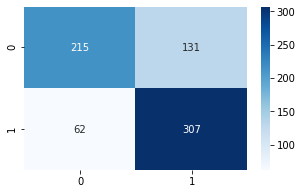

In [0]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(cm, index = [i for i in "01"], columns = [i for i in "01"])
plt.figure(figsize = (5, 3))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

#### Logistic Regression

In [0]:
clf = LogisticRegression(random_state=0)
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)
name = 'logistic reg'
print('Accuracy of {}:'.format(name), accuracy_score(y_pred, y_test))
print('Precision', precision_score(y_test, y_pred))
print('Recall', recall_score(y_test, y_pred))
print('F1-Score', f1_score(y_test, y_pred))

Accuracy of logistic reg: 0.7188811188811188
Precision 0.7058823529411765
Recall 0.7804878048780488
F1-Score 0.7413127413127415


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


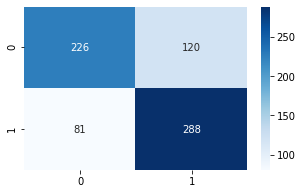

In [0]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(cm, index = [i for i in "01"], columns = [i for i in "01"])
plt.figure(figsize = (5, 3))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

### Doc2Vec

In [0]:
dm_doc_vec_scaled = scaler.fit_transform(dm_doc_vec)
dm_doc_vec_scaled

array([[ 0.47037034, -2.33977052,  0.71333959, ...,  0.0847579 ,
        -0.46463376, -1.1069673 ],
       [-1.54237169,  0.77291785,  1.25473401, ..., -1.07749886,
         0.20396561, -2.10887519],
       [ 2.60738543,  0.23128768, -2.1852153 , ..., -1.71847879,
         1.11856247, -0.795137  ],
       ...,
       [-0.59276201, -0.97654939, -0.00714849, ...,  2.09843374,
         0.79985532, -0.05527295],
       [ 0.23847264,  0.22538708, -1.58579055, ..., -0.13056522,
         0.01079704, -0.05522915],
       [ 1.48407927, -0.09982888, -0.27034877, ...,  1.33985737,
        -0.29028646,  0.90179166]])

In [0]:
X_train_doc = dm_doc_vec_scaled[:len(train)]
y_train_doc = train['label']

X_test_doc = dm_doc_vec_scaled[len(train):] #dm_doc_vec_scaled
y_test_doc = test['label']

# X = dm_doc_vec_scaled
# y = train['label']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [0]:
for name, clf in clf_dict.items():
    model = clf.fit(X_train_doc, y_train_doc)
    y_pred_doc = model.predict(X_test_doc)
    print('Accuracy of {}:'.format(name), accuracy_score(y_pred_doc, y_test_doc))

Accuracy of log reg: 0.7244755244755244
Accuracy of naive bayes: 0.6489510489510489
Accuracy of linear svc: 0.7132867132867133
Accuracy of sgd classifier: 0.6783216783216783
Accuracy of ada boost: 0.6951048951048951
Accuracy of gradient boosting: 0.7062937062937062
Accuracy of CART: 0.558041958041958
Accuracy of random forest: 0.6755244755244755


#### XGBoost

In [0]:
D_train_doc = xgb.DMatrix(X_train_doc, label=y_train_doc)
D_test_doc = xgb.DMatrix(X_test_doc, label=y_test_doc)
params = {"objective":'multi:softprob','max_depth': 3, 'alpha': 10 , 'num_class': 2, 'random_state': 0}
steps = 20  # The number of training iterations
model = xgb.train(params, D_train_doc, steps)
preds = model.predict(D_test_doc)
y_pred_doc = np.asarray([np.argmax(line) for line in preds])

In [0]:
name = 'XGBoost'
print('Accuracy of {}:'.format(name), accuracy_score(y_pred_doc, y_test_doc))
print('Precision', precision_score(y_test_doc, y_pred_doc))
print('Recall', recall_score(y_test_doc, y_pred_doc))
print('F1-Score', f1_score(y_test_doc, y_pred_doc))

Accuracy of XGBoost: 0.6853146853146853
Precision 0.6674418604651163
Recall 0.7777777777777778
F1-Score 0.718397997496871


#### Logistic Regression

In [0]:
clf = LogisticRegression(random_state=0).fit(X_train_doc, y_train_doc)
y_pred_doc = clf.predict(X_test_doc)

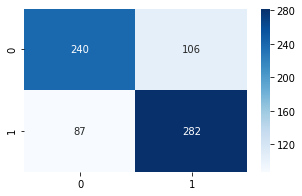

In [0]:
# Confusion Matrix
cm = confusion_matrix(y_test_doc, y_pred_doc)

df_cm = pd.DataFrame(cm, index = [i for i in "01"], columns = [i for i in "01"])
plt.figure(figsize = (5, 3))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

In [0]:
name = 'logistic reg'
print('Accuracy of {}:'.format(name), accuracy_score(y_pred_doc, y_test_doc))
print('Precision', precision_score(y_test_doc, y_pred_doc))
print('Recall', recall_score(y_test_doc, y_pred_doc))
print('F1-Score', f1_score(y_test_doc, y_pred_doc))

Accuracy of logistic reg: 0.7244755244755244
Precision 0.7205128205128205
Recall 0.7615176151761518
F1-Score 0.7404479578392622


### Doc2Vec + Word2Vec

In [0]:
dm_doc_vec_scaled = scaler.fit_transform(dm_doc_vec)
fts = []
for i in range(len(tfidf_doc_vec)):
  # combine doc2vec and word2vec features
  ft = list(tfidf_doc_vec_scaled[i]) + list(dm_doc_vec_scaled[i])
  fts.append(ft)
# (3553, 600)
fts = np.array(fts)

In [0]:
X = fts #scaler.fit_transform(fts)

X_train_combine = X[:len(train)]
y_train_combine = train['label']

X_test_combine = X[len(train):]
y_test_combine = test['label']

In [0]:
for name, clf in clf_dict.items():
    model = clf.fit(X_train_combine, y_train_combine)
    y_pred_combine = model.predict(X_test_combine)
    print('Accuracy of {}:'.format(name), accuracy_score(y_pred_combine, y_test_combine))
    print('F1-score of {}:'.format(name), f1_score(y_test_combine, y_pred_combine))

Accuracy of log reg: 0.7160839160839161
F1-score of log reg: 0.7380645161290323
Accuracy of naive bayes: 0.6629370629370629
F1-score of naive bayes: 0.727683615819209
Accuracy of linear svc: 0.6979020979020979
F1-score of linear svc: 0.7165354330708661
Accuracy of sgd classifier: 0.6867132867132867
F1-score of sgd classifier: 0.7044854881266491
Accuracy of ada boost: 0.6895104895104895
F1-score of ada boost: 0.718274111675127
Accuracy of gradient boosting: 0.7286713286713287
F1-score of gradient boosting: 0.7599009900990098
Accuracy of CART: 0.6223776223776224
F1-score of CART: 0.6465968586387435
Accuracy of random forest: 0.73006993006993
F1-score of random forest: 0.760248447204969


#### Random Forest

In [0]:
clf = RandomForestClassifier(random_state=42).fit(X_train_combine, y_train_combine)
y_pred_combine = clf.predict(X_test_combine)

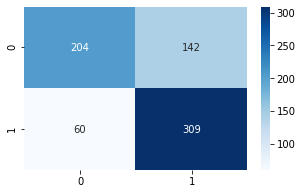

In [0]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(cm, index = [i for i in "01"], columns = [i for i in "01"])
plt.figure(figsize = (5, 3))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

In [0]:
print('Accuracy', accuracy_score(y_test_combine, y_pred_combine))
print('Precision', precision_score(y_test_combine, y_pred_combine))
print('Recall', recall_score(y_test_combine, y_pred_combine))
print('F1-Score', f1_score(y_test_combine, y_pred_combine))

Accuracy 0.73006993006993
Precision 0.7018348623853211
Recall 0.8292682926829268
F1-Score 0.760248447204969
